<a href="https://colab.research.google.com/github/pandian-ra/EVA4_Session6/blob/master/L1_lamda__0_0001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import random


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                    #    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                    #    transforms.RandomRotation((-5.0, 5.0), fill=(1,)),                                      
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [80]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.10
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12
        
        # CONVOLUTION BLOCK 2
        self.convblock22 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        # CONVOLUTION BLOCK 3
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),            
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),            
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=22, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(22),
            nn.Dropout(dropout_value)
        ) # output_size = 4


        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 3
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=22, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock22(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        # x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [82]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]             160
           Conv2d-11           [-1, 10, 10, 10]             900
      BatchNorm2d-12           [-1, 10, 10, 10]              20
             ReLU-13           [-1, 10, 10, 10]               0
          Dropout-14           [-1

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
# LAMDA = 0.001
def train(model, device, train_loader, optimizer, epoch, LAMDA):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  criterion= nn.CrossEntropyLoss().to(device)

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    regularization_loss = 0
    for param in model.parameters():
        regularization_loss += torch.sum(abs(param))
 
    classify_loss = criterion(y_pred,target)
    # loss = F.nll_loss(y_pred, target)
    loss = classify_loss + LAMDA * regularization_loss
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [85]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, 0.0001)
    # scheduler.step()
    test(model, device, test_loader)        

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.15888842940330505 Batch_id=468 Accuracy=89.82: 100%|██████████| 469/469 [00:24<00:00, 18.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9812/10000 (98.12%)

EPOCH: 1


Loss=0.11332269012928009 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:24<00:00, 18.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0684, Accuracy: 9792/10000 (97.92%)

EPOCH: 2


Loss=0.08083128929138184 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:24<00:00, 19.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.11475670337677002 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:24<00:00, 19.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9914/10000 (99.14%)

EPOCH: 4


Loss=0.12293176352977753 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:24<00:00, 19.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9930/10000 (99.30%)

EPOCH: 5


Loss=0.09914857149124146 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.07728715986013412 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:24<00:00, 18.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.09429421275854111 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9894/10000 (98.94%)

EPOCH: 8


Loss=0.08943560719490051 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:25<00:00, 18.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.0706949234008789 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:24<00:00, 21.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.06339646130800247 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:24<00:00, 19.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9915/10000 (99.15%)

EPOCH: 11


Loss=0.06979366391897202 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:24<00:00, 18.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.06709394603967667 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:24<00:00, 18.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.07909271121025085 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:24<00:00, 18.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Loss=0.11003060638904572 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.15804904699325562 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:25<00:00, 18.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9918/10000 (99.18%)

EPOCH: 16


Loss=0.07845744490623474 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:24<00:00, 18.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9918/10000 (99.18%)

EPOCH: 17


Loss=0.0948055237531662 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:25<00:00, 18.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9922/10000 (99.22%)

EPOCH: 18


Loss=0.10307346284389496 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.07819631695747375 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:24<00:00, 18.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9920/10000 (99.20%)

EPOCH: 20


Loss=0.08641281723976135 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:24<00:00, 18.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.09699894487857819 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:24<00:00, 18.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9889/10000 (98.89%)

EPOCH: 22


Loss=0.06498300284147263 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:24<00:00, 19.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9943/10000 (99.43%)

EPOCH: 23


Loss=0.07453928142786026 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:24<00:00, 19.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.06086280941963196 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 25


Loss=0.06377539783716202 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:24<00:00, 19.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9941/10000 (99.41%)

EPOCH: 26


Loss=0.08444313704967499 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:24<00:00, 19.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)

EPOCH: 27


Loss=0.09467896074056625 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9916/10000 (99.16%)

EPOCH: 28


Loss=0.0676267221570015 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:24<00:00, 18.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9935/10000 (99.35%)

EPOCH: 29


Loss=0.06527885049581528 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:24<00:00, 19.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9920/10000 (99.20%)

EPOCH: 30


Loss=0.06326201558113098 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:23<00:00, 19.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9924/10000 (99.24%)

EPOCH: 31


Loss=0.06581591069698334 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:24<00:00, 19.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)

EPOCH: 32


Loss=0.06918001919984818 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9919/10000 (99.19%)

EPOCH: 33


Loss=0.056408606469631195 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)

EPOCH: 34


Loss=0.06574392318725586 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:23<00:00, 19.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

EPOCH: 35


Loss=0.09709487110376358 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:23<00:00, 19.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9918/10000 (99.18%)

EPOCH: 36


Loss=0.05401160567998886 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:24<00:00, 19.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9915/10000 (99.15%)

EPOCH: 37


Loss=0.07775364816188812 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:23<00:00, 19.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 38


Loss=0.09215091913938522 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:24<00:00, 19.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9930/10000 (99.30%)

EPOCH: 39


Loss=0.07295921444892883 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]



Test set: Average loss: 0.0205, Accuracy: 9927/10000 (99.27%)



Text(0.5, 1.0, 'Test Accuracy')

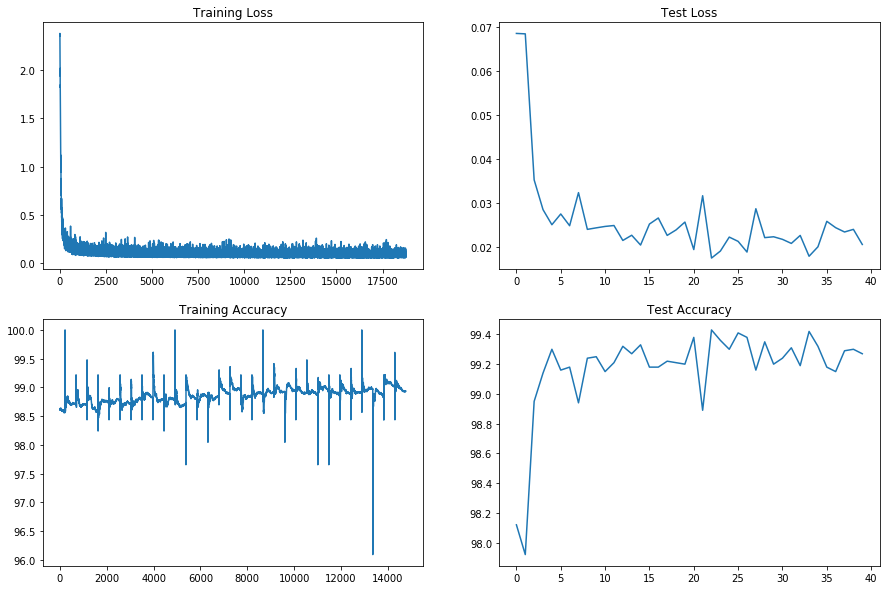

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
import json

with open('test_acc_l1.txt', 'w') as filehandle:
    json.dump(test_acc, filehandle)

In [0]:
with open('test_acc_l1.txt', 'r') as filehandle:
    basicList = json.load(filehandle)


In [93]:
basicList == test_losses

True

In [0]:
import json

with open('test_losses_l1.txt', 'w') as filehandle:
    json.dump(test_losses, filehandle)

In [0]:
with open('test_losses_l1.txt', 'r') as filehandle:
    basicList = json.load(filehandle)


In [0]:
# torch.save(model, 'filename.pt')
torch.save(model.state_dict(), 'l1_0_0001.pt')

# Then later:
# model = torch.load(filepath)


In [0]:
criterion = nn.CrossEntropyLoss()
batch_size = 128

In [0]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        model.eval()
        output = model(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [0]:
def wrong_plot(true,ima,pred,encoder,inv_normalize,n_figures ):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/5)
    fig,axes = plt.subplots(figsize=(10, 10), nrows = n_row, ncols=5)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+str(c.item()) + ',' +'P:'+str(w.item())
        f = 'A:'+str(correct) + ',' +'P:'+str(wrong)
        # image = image.numpy().transpose(1,2,0)
        image = image.squeeze()
        im = ax.imshow(image, cmap='gray', interpolation='none')
        ax.set_title(f)
        ax.axis('off')
    plt.show()

In [99]:
true,pred,image,true_wrong,pred_wrong = test(test_loader)

tensor(0.9817, device='cuda:0', dtype=torch.float64) 0.020264252218641813


Classes in order Actual and Predicted


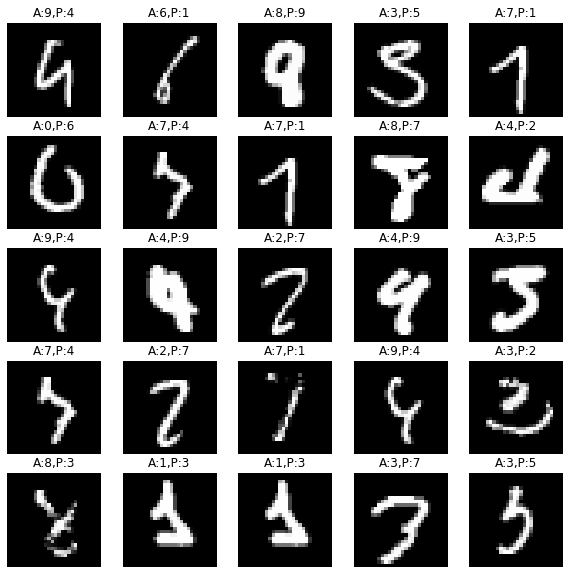

In [100]:
wrong_plot(true_wrong,image,pred_wrong,test_loader.dataset.targets,None,25)